  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

           InvoiceDate  UnitPrice  CustomerID         Country  
0  2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1  2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2  2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3  2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4  2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
Index: 397924 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       ----------

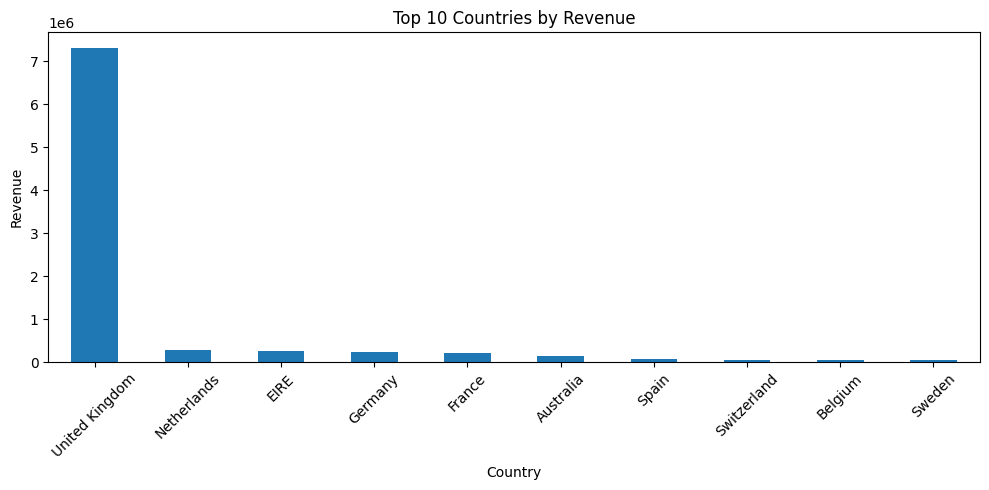

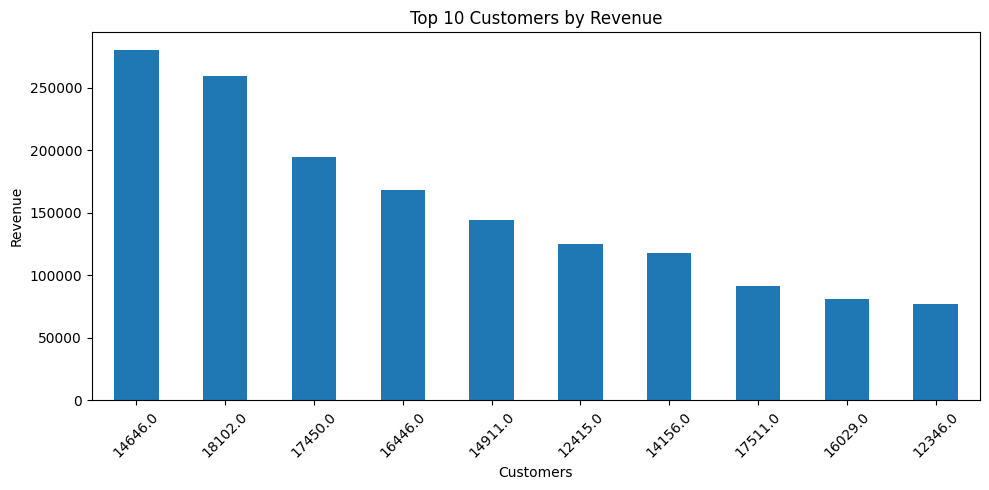

CustomerID
12748.0    210
14911.0    201
17841.0    124
13089.0     97
14606.0     93
15311.0     91
12971.0     86
14646.0     74
16029.0     63
13408.0     62
Name: InvoiceNo, dtype: int64


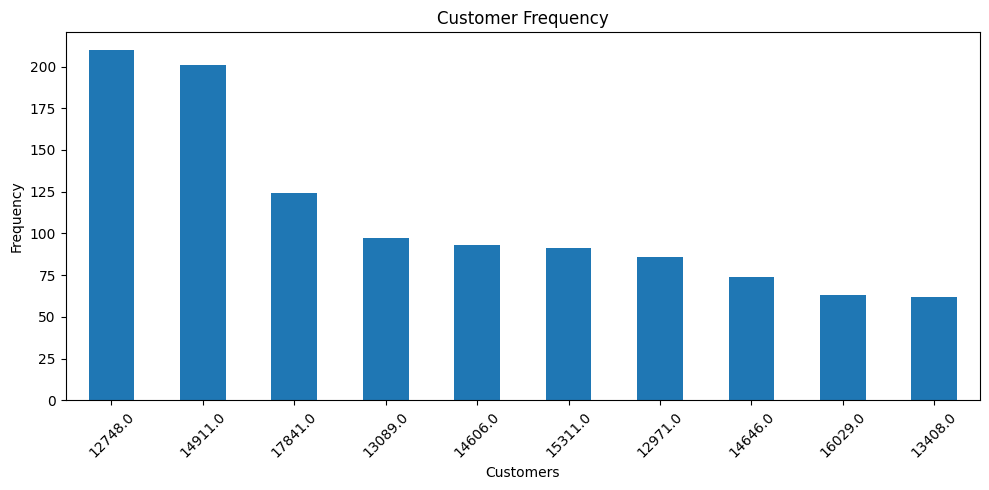

churn
False    2894
True     1445
Name: count, dtype: int64
Churn Rate: 33.30260428670201


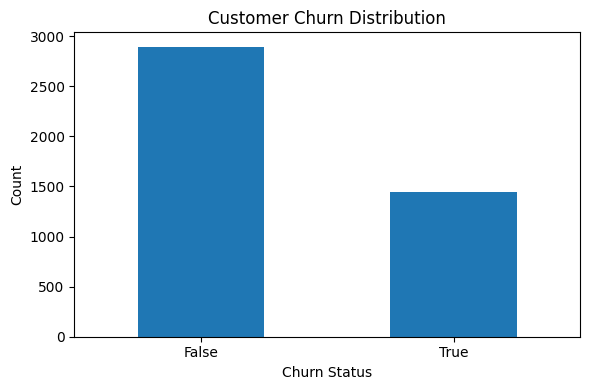

            Recency  Frequency  Monetary R_Score F_Score M_Score RFM_Score
CustomerID                                                                
12346.0         325          1  77183.60       1       1       5       115
12347.0           1          7   4310.00       5       5       5       555
12348.0          74          4   1797.24       2       4       4       244
12349.0          18          1   1757.55       4       1       4       414
12350.0         309          1    334.40       1       1       2       112
Segment
Potential Loyalists    1222
Lost Customers         1065
Champions               962
Loyal Customers         687
At Risk                 403
Name: count, dtype: int64


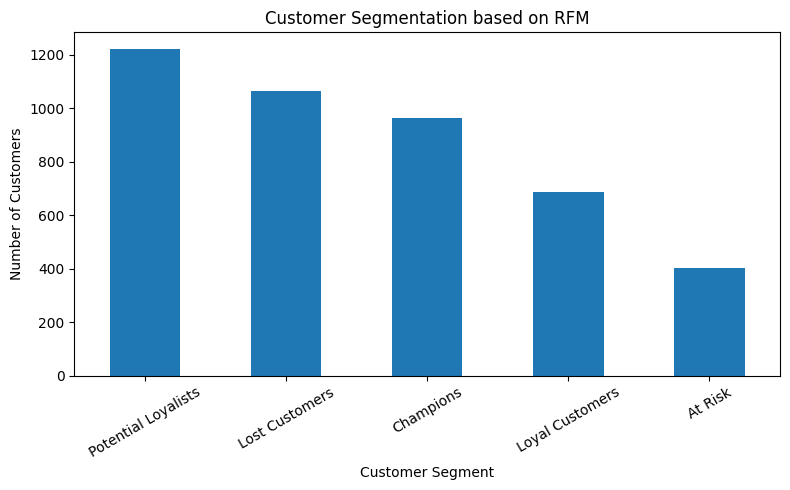

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/content/online_retail.csv', encoding = 'ISO-8859-1')
print(df.head())
df = df.dropna(subset=['CustomerID'])
df = df[df['Quantity'] > 0]
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
print(df.info())
print(df.head())
print('Total Transactions:',df.shape[0])
print('Unique Customers:', df['CustomerID'].nunique())
print('Total Revenue:',df['TotalPrice'].sum())
print('Countries served:',df['Country'].nunique())
country_sales = (
    df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False)
)
print(country_sales.head(10))

top10_countries = country_sales.head(10)
top10_countries.plot(kind='bar', figsize=(10,5), title='Top 10 Countries by Revenue')
plt.xlabel('Country')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

top_customers = (
    df.groupby('CustomerID')['TotalPrice'].sum().sort_values(ascending=False).head(10)
)
top10_customers = top_customers.head(10)
top10_customers.plot(kind='bar', figsize=(10,5), title='Top 10 Customers by Revenue')
plt.xlabel('Customers')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

customer_freq = (
    df.groupby('CustomerID')['InvoiceNo'].nunique().sort_values(ascending=False)
)
print(customer_freq.head(10))
customer_freq.head(10).plot(kind='bar', figsize=(10,5), title='Customer Frequency')
plt.xlabel('Customers')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
df['InvoiceDate'].max()
last_purchase = df.groupby('CustomerID')['InvoiceDate'].max()
last_purchase.head()
latest_date = df['InvoiceDate'].max()
latest_date
churn_df = pd.DataFrame(last_purchase)
churn_df['Days'] = (
    latest_date - churn_df['InvoiceDate']
).dt.days
churn_df.head()

churn_df['churn'] = churn_df['Days'] > 90
churn_df.head()
churn_counts = churn_df['churn'].value_counts()
print(churn_counts)
churn_rates = churn_counts[True] / churn_counts.sum() * 100
print(f'Churn Rate:',churn_rates)
churn_counts.plot(kind='bar', figsize=(6,4), title = 'Customer Churn Distribution')
plt.xlabel('Churn Status')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

rfm_date = df['InvoiceDate'].max()
rfm_date
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate' : lambda x : (rfm_date - x.max()).days,
    'InvoiceNo' : 'nunique',
    'TotalPrice' :'sum'
})
rfm_columns = ['Recency', 'Frequency', 'Monetary']
rfm.columns = rfm_columns

# Using rank(method='first') to handle non-unique bin edges for Frequency
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])
rfm['RFM_Score'] = (
    rfm['R_Score'].astype(str) +
    rfm['F_Score'].astype(str) +
    rfm['M_Score'].astype(str)
)
print(rfm.head())

def segment_customer(row):
    # Using integer comparisons instead of strings
    if row['R_Score'] >= 4 and row['F_Score'] >= 4 and row['M_Score'] >= 4:
        return 'Champions'
    elif row['F_Score'] >= 4 and row['M_Score'] >= 3:
        return 'Loyal Customers'
    elif row['R_Score'] <= 2 and row['F_Score'] >= 3:
        return 'At Risk'
    elif row['R_Score'] <= 2 and row['F_Score'] <= 2:
        return 'Lost Customers'
    else:
        return 'Potential Loyalists'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)
print(rfm['Segment'].value_counts())
rfm['Segment'].value_counts().plot(
    kind='bar',
    figsize=(8,5),
    title='Customer Segmentation based on RFM'
)
plt.xlabel('Customer Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()